In [ ]:
import numpy as np
import os
import tensorflow as tf
import shutil
import random
import cv2
from tensorflow import keras
import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt
# from google.colab import drive, files
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Activation
from keras.optimizers import Adam
from keras.models import Model
# from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
# from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('model_training')

Drive already mounted at model_training; to attempt to forcibly remount, call drive.mount("model_training", force_remount=True).


In [ ]:
# Path ke folder dataset
dataset_folder = os.path.join('/content/model_training/MyDrive/RISET_CNN/dataset/rawdata')

# Path ke folder tempat Anda ingin menyimpan data pelatihan dan validasi
output_folder = os.path.join('/content/model_training/MyDrive/RISET_CNN/dataset/dataset')
training_folder = os.path.join(output_folder, 'training')
validation_folder = os.path.join(output_folder, 'validation')

In [ ]:
# # Path ke folder dataset
# dataset_folder = 'F:\\A-Project-CNN\\cnn-mr-team\\datasets\\resize\\rawdata'
# # Path ke folder tempat Anda ingin menyimpan data pelatihan dan validasi
# output_folder = 'F:\\A-Project-CNN\\cnn-mr-team\\datasets\\resize\\dataset'
# training_folder = os.path.join(output_folder, 'training')
# validation_folder = os.path.join(output_folder, 'validation')

In [ ]:
def split_images(dataset_folder, training_folder, validation_folder):
    for npm_folder in os.listdir(dataset_folder):
        filename = os.listdir(os.path.join(dataset_folder, npm_folder))
        random.seed(42)
        random.shuffle(filename)
        train_ratio = int(0.8 * len(filename))
        train_filenames = filename[:train_ratio]
        val_filenames = filename[train_ratio:]
        for img in train_filenames:
            src_path = os.path.join(dataset_folder, npm_folder, img)
            dst_path = os.path.join(training_folder, npm_folder, img)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)
        for img in val_filenames:
            src_path = os.path.join(dataset_folder, npm_folder, img)
            dst_path = os.path.join(validation_folder, npm_folder, img)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path,dst_path)

In [ ]:
split_images(dataset_folder, training_folder, validation_folder)

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1/255)
validate_data_gen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_gen = train_data_gen.flow_from_directory(training_folder, (128,128))
validate_gen = validate_data_gen.flow_from_directory(validation_folder, (128,128))

Found 66 images belonging to 4 classes.
Found 18 images belonging to 4 classes.


In [ ]:
# Fungsi untuk membangun blok konvolusi ResNet
def conv_block(x, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [ ]:
# Fungsi untuk membangun blok ResNet
def resnet_block(x, filters, num_blocks, stride):
    shortcut = x

    for i in range(num_blocks):
        if i == 0:
            x = conv_block(x, filters, kernel_size=(3, 3), strides=stride)
        else:
            x = conv_block(x, filters, kernel_size=(3, 3), strides=1)

    # Skip connection
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [ ]:
# Model ResNet-50
def ResNet50(input_shape=(128,128, 3), num_classes=4):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = resnet_block(x, 64, 3, stride=1)
    x = resnet_block(x, 128, 4, stride=2)
    x = resnet_block(x, 256, 6, stride=2)
    x = resnet_block(x, 512, 3, stride=2)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor, outputs=x, name='resnet50')
    return model

In [ ]:
model = ResNet50()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
saveBestModel = tf.keras.callbacks.ModelCheckpoint('/content/model_training/MyDrive/RISET_CNN/ResNet50_BestModel.h5',
                                                   monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=2,
                    epochs=400,
                    validation_data=validate_gen,
                    validation_split=0.2,
                    callbacks=[saveBestModel]
                    )

Epoch 1/400
2/2 [==============================] - ETA: 0s - loss: 2.1522 - accuracy: 0.2059  
Epoch 1: val_accuracy improved from -inf to 0.22222, saving model to /content/model_training/MyDrive/RISET_CNN/ResNet50_BestModel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 66s 2s/step - loss: 2.1522 - accuracy: 0.2059 - val_loss: 1.3871 - val_accuracy: 0.2222
Epoch 2/400
2/2 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.7941
Epoch 2: val_accuracy did not improve from 0.22222
2/2 [==============================] - 4s 4s/step - loss: 0.6812 - accuracy: 0.7941 - val_loss: 1.3874 - val_accuracy: 0.2222
Epoch 3/400
2/2 [==============================] - ETA: 0s - loss: 0.4047 - accuracy: 0.8529
Epoch 3: val_accuracy improved from 0.22222 to 0.44444, saving model to /content/model_training/MyDrive/RISET_CNN/ResNet50_BestModel.h5
2/2 [==============================] - 8s 7s/step - loss: 0.4047 - accuracy: 0.8529 - val_loss: 1.3876 - val_accuracy: 0.4444
Epoch 4/400
2/2 [==============================] - ETA: 0s - loss: 0.5035 - accuracy: 0.8235
Epoch 4: val_accuracy did not improve from 0.44444
2/2 [==============================] - 4s 4s/step - loss: 0.5035 - accuracy: 0.8235 - val_loss: 1.3890 -

In [ ]:
best_model = keras.models.load_model('/content/model_training/MyDrive/RISET_CNN/ResNet50_BestModel.h5')

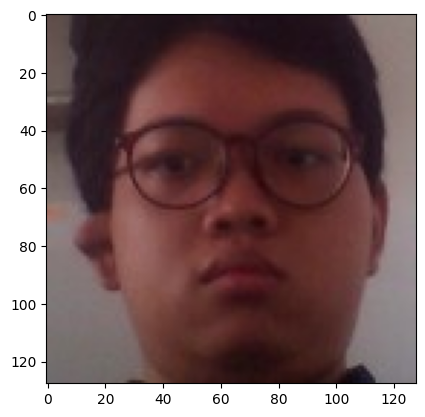

1/1 [==============================] - 0s 427ms/step
['2117051027']


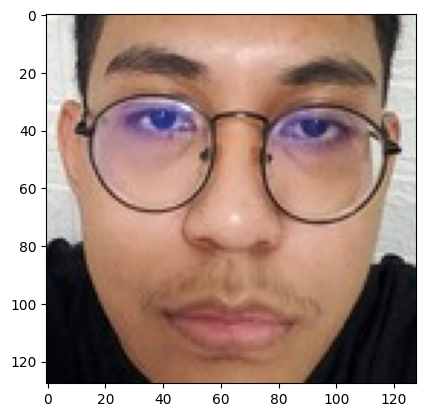

1/1 [==============================] - 0s 60ms/step
['2117051027']


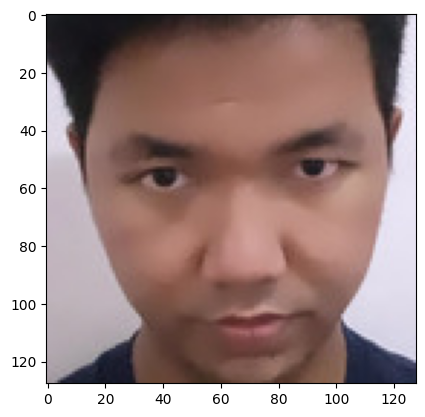

1/1 [==============================] - 0s 57ms/step
['2117051027']


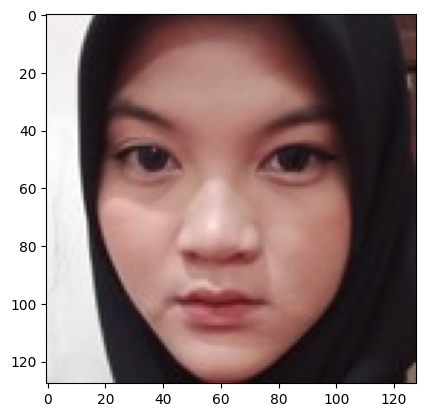

1/1 [==============================] - 0s 54ms/step
['2117051043']


In [ ]:
data_test = '/content/model_training/MyDrive/RISET_CNN/dataset/testing/'

for filename in os.listdir(data_test):
  image_path = os.path.join(data_test, filename)
  img = image.load_img(image_path, target_size=(128,128))
  if img.mode == 'RGBA':
    img = img.convert('RGB')
  plt.imshow(img)
  plt.show()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

  predictions = best_model.predict(img)

  predictions = np.argmax(predictions, axis=1)

  labels = (train_gen.class_indices)
  labels = dict((i,j) for j,i in labels.items())

  predictions = [labels[i] for i in predictions]
  print(predictions)